#₊𖥔  CNN com CIFAR-10  ! ۪ ׄ໑୧


## Dados + Teoria

In [1]:
# Built-in
import os
import math
import random
import time
import pickle
from pathlib import Path
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any, Optional

# Third-party
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import torchvision.transforms as T
from PIL import Image

#### Leitura Inicial do Dados

In [2]:
# Função para carregar os dados do CIFAR-10 (do website)
def unpickle(file):
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

CIFAR_DIR = Path("..") / "data" / "cifar-10-batches-py"

TRAIN_BATCHES = [f"data_batch_{i}" for i in range(1, 6)]
TEST_BATCH = "test_batch"
META_FILE = "batches.meta"


# ===== para evitar futuros erros
def ensure_exists(p: Path):
    if not p.exists():
        raise FileNotFoundError(f"Arquivo não encontrado: {p}\n"
                                f"Verifique o caminho ou baixe o CIFAR-10 (https://www.cs.toronto.edu/~kriz/cifar.html.")

#### Conjuntos de Treinamento e Teste

In [3]:
def load_cifar10_numpy(cifar_dir: Path):
    """
    Retorna:
      X_train: (50000, 3, 32, 32) uint8
      y_train: (50000,) int
      X_test : (10000,  3, 32, 32) uint8
      y_test : (10000,) int
      classes: list[str] com 10 nomes
    """
    # Meta
    meta_path = cifar_dir / META_FILE
    ensure_exists(meta_path)
    meta = unpickle(meta_path)
    classes = [c.decode("utf-8") for c in meta[b"label_names"]]

    # Train
    X_train_chunks = []
    y_train_chunks = []
    for fname in TRAIN_BATCHES:
        fpath = cifar_dir / fname
        ensure_exists(fpath)
        obj = unpickle(fpath)  # dict com chaves b'data', b'labels'
        data = obj[b"data"]  # (10000, 3072) uint8
        labels = np.array(obj[b"labels"], dtype=np.int64)  # (10000,)

        # reshape para (N, 3, 32, 32)
        # Formato original: cada linha = [R(1024), G(1024), B(1024)]
        data = data.reshape(-1, 3, 32, 32)
        X_train_chunks.append(data)
        y_train_chunks.append(labels)

    X_train = np.concatenate(X_train_chunks, axis=0)
    y_train = np.concatenate(y_train_chunks, axis=0)

    # Test
    test_path = cifar_dir / TEST_BATCH
    ensure_exists(test_path)
    obj_test = unpickle(test_path)
    X_test = obj_test[b"data"].reshape(-1, 3, 32, 32)
    y_test = np.array(obj_test[b"labels"], dtype=np.int64)

    # sanity checks
    assert X_train.shape == (50000, 3, 32, 32)
    assert X_test.shape  == (10000,  3, 32, 32)
    assert y_train.shape == (50000,)
    assert y_test.shape  == (10000,)

    return X_train, y_train, X_test, y_test, classes

# Update CIFAR_DIR to the correct path based on file inspection
CIFAR_DIR = Path("/content/")

X_train, y_train, X_test, y_test, classes = load_cifar10_numpy(CIFAR_DIR)

print("Classes:", classes)
print(f"\nX_train: {X_train.shape}, {X_train.dtype}")
print(f"y_train: {y_train.shape}, {y_train.dtype}")
print(f"X_test : {X_test.shape}, {X_test.dtype}")
print(f"y_test : {y_test.shape}, {y_test.dtype}")

Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

X_train: (50000, 3, 32, 32), uint8
y_train: (50000,), int64
X_test : (10000, 3, 32, 32), uint8
y_test : (10000,), int64


#### Exibindo estrutura do dado como sinais 1D/2D/3D

In [4]:
# =========================
def as_1d_vector(img_chw: np.ndarray) -> np.ndarray:
    """
    img_chw: (3, 32, 32) uint8
    retorno: (3072,) uint8
    """
    return img_chw.reshape(-1)

# =========================
def as_2d_grayscale(img_chw: np.ndarray, method: str = "luminosity") -> np.ndarray:
    """
    Converte RGB -> cinza (32x32) usando:
      - 'avg'          : média simples
      - 'luminosity'   : 0.299*R + 0.587*G + 0.114*B (padrão)
    Retorno: (32, 32) float32 na faixa [0,255]
    """
    r, g, b = img_chw[0].astype(np.float32), img_chw[1].astype(np.float32), img_chw[2].astype(np.float32)
    if method == "avg":
        gray = (r + g + b) / 3.0
    else:
        gray = 0.299 * r + 0.587 * g + 0.114 * b
    return gray

# =========================
def as_3d_rgb(img_chw: np.ndarray) -> np.ndarray:
    """
    Converte (3,32,32) -> (32,32,3) para exibição no matplotlib.
    """
    return np.transpose(img_chw, (1, 2, 0))

Índice: 12 | Classe: horse (7)
Formas -> 1D: (3072,),
        2D: (32, 32),
       3D: (32, 32, 3)

Primeiros 20 elementos do vetor 1D: [164 162 162 163 162 163 164 164 165 165 165 165 165 165 165 165 165 165
 165 165]


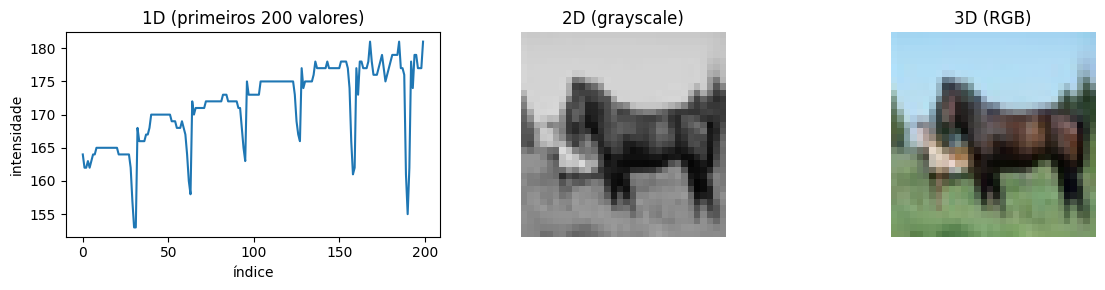

In [5]:
# =========================
def show_sample_views(X: np.ndarray, y: np.ndarray, classes: list[str], idx: int = 0):
    """
    Mostra o mesmo exemplo como:
      - Vetor 1D (exibe só um "trecho" do vetor para visualização)
      - Imagem 2D em escala de cinza
      - Tensor RGB (3D) como imagem colorida
    """
    img = X[idx]              # (3,32,32)
    label_idx = int(y[idx])
    label = classes[label_idx]

    vec_1d = as_1d_vector(img)
    gray_2d = as_2d_grayscale(img)
    rgb_3d = as_3d_rgb(img)

    print(f"Índice: {idx} | Classe: {label} ({label_idx})")
    print(f"Formas -> 1D: {vec_1d.shape},\n        2D: {gray_2d.shape},\n       3D: {rgb_3d.shape}")
    print(f"\nPrimeiros 20 elementos do vetor 1D: {vec_1d[:20]}")

    # Plotagens simples
    plt.figure(figsize=(12, 3))

    # 1D: mostramos um "sinal" com os primeiros 200 valores do vetor
    plt.subplot(1, 3, 1)
    plt.plot(vec_1d[:200])
    plt.title("1D (primeiros 200 valores)")
    plt.xlabel("índice")
    plt.ylabel("intensidade")

    # 2D: grayscale
    plt.subplot(1, 3, 2)
    plt.imshow(gray_2d, cmap="gray", vmin=0, vmax=255)
    plt.title("2D (grayscale)")
    plt.axis("off")

    # 3D: RGB
    plt.subplot(1, 3, 3)
    plt.imshow(rgb_3d)
    plt.title("3D (RGB)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

show_sample_views(X_train, y_train, classes, idx=12)

#### Estatísticas por canal (média/desvio) para normalização

Vamos calcular a média (mean) e desvio-padrão (std) por canal para fazer a normalização dos dados antes de alimentar a rede.
Calculadas apenas no treino. Em escala [0,1] (compatível com ToTensor() do torchvision).


In [6]:
def compute_channel_stats_01(X_train_chw_uint8: np.ndarray):
    """
    X_train: (N, 3, 32, 32) uint8 - CHW (Channels-First)
    Retorna mean,std por canal (em [0,1]) como listas de floats para usar no Normalize.
    """
    X = X_train_chw_uint8.astype(np.float32)  # Converte o array e escala os pixels de 0–255 para 0–1
    # eixo 0=N, 2=H, 3=W -> média por canal
    mean = (X_train_chw_uint8.mean(axis=(0,2,3)) / 255.0).tolist()          # len=3 [mean_R, mean_G, mean_B].
    std  = (X_train_chw_uint8.std(axis=(0,2,3), ddof=0) / 255.0).tolist()

    return mean, std

# uso:
mean, std = compute_channel_stats_01(X_train)
print("mean:", mean, "std:", std)

mean: [0.49139967861519607, 0.48215840839460783, 0.44653091444546567] std: [0.24703223246328176, 0.24348512800005648, 0.26158784172796473]


#### Demonstração Conceitual: Zero Padding + Convolução/Correlação

In [7]:
# =========================
def zero_pad_1d(x: np.ndarray, pad_left: int, pad_right: int):
    """
    Pega um vetor 1D x.Adiciona pad_left zeros à esquerda e pad_right zeros à direita.
    Retorna [0...0, x, 0...0] com zeros anexados à esquerda e à direita.
    """
    assert pad_left >= 0 and pad_right >= 0
    if pad_left == 0 and pad_right == 0:
        return x
    return np.pad(x, (pad_left, pad_right), mode='constant', constant_values=0)


# =========================
def xcorr_unnormalized(s: np.ndarray, g: np.ndarray):
    """
    Calcula correlação cruzada entre sinal s e kernel g
    Implementada via convolução com g invertido, 'full' para cobrir todos os deslocamentos.
    r tem tamanho len(s)+len(g)-1.
    """
    s = np.asarray(s, dtype=np.float64)
    g = np.asarray(g, dtype=np.float64)
    if len(g) >= len(s):
        raise ValueError(f"O sinal g deve ter dimensão estritamente menor que s. len(g)={len(g)} >= len(s)={len(s)}")
    r = np.convolve(s, g[::-1], mode='full')
    return r


# =========================
def demo_xcorr_from_cifar_channel(X_train: np.ndarray, idx_img: int = 0, channel: int = 0, g: np.ndarray | None = None, pad_left: int = 0, pad_right: int = 0):
    """
    Exemplo:
      - Extrai um canal (32x32) da img idx_img do treino.
      - Achata em 1D (s).
      - (Opcional) faz zero padding em s.
      - Correla s com g (definido ou gerado).
    Retorna: s, s_padded, g, r
    """
    img_chw = X_train[idx_img].astype(np.float64)  # (3,32,32)
    s = img_chw[channel].reshape(-1)               # (1024,) -> 1D
    if g is None:
        # kernel curto de exemplo (qualquer vetor 1D mais curto que s serve)
        g = np.array([1, -1, 2, 0, -2, 1], dtype=np.float64)

    # zero padding
    s_pad = zero_pad_1d(s, pad_left, pad_right)

    # correlação não-normalizada
    r = xcorr_unnormalized(s_pad, g)
    # Verificações
    # len(r) = len(s_pad) + len(g) - 1
    assert len(r) == len(s_pad) + len(g) - 1

    return s, s_pad, g, r



# ========================= Exemplo:
s, s_pad, g, r = demo_xcorr_from_cifar_channel(X_train, idx_img=0, channel=0, pad_left=10, pad_right=10)
print(f"Vetor original (s): {len(s)}, \nVetor com padding (s_pad): {len(s_pad)}, \nKernel (g): {len(g)} elementos, \nResultado da correlação (r): {len(r)}")  # 1024, 1044, 6, 1049


Vetor original (s): 1024, 
Vetor com padding (s_pad): 1044, 
Kernel (g): 6 elementos, 
Resultado da correlação (r): 1049


## Validação

#### Split estratificado treino/val (45k/5k)

In [8]:
def stratified_train_val_split(X: np.ndarray, y: np.ndarray, val_size: int = 5000, random_state: int = 42):
    """
    X: (50000, 3, 32, 32) ; y: (50000,)
    val_size: número absoluto de amostras de validação (ex: 5000)
    Retorna índices: idx_train, idx_val
    """
    assert len(X) == 50000 and len(y) == 50000, "Esperado conjunto de treino original (50k)."
    test_size = val_size / len(X)

    # Cada classe do CIFAR-10 terá ≈10% das amostras movidas para validação
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    idx_train, idx_val = next(splitter.split(X, y))
    return idx_train, idx_val

# ========== aplicação:
idx_train, idx_val = stratified_train_val_split(X_train, y_train, val_size=5000)
print(f"Train: {len(idx_train)}, Val: {len(idx_val)}")  # 45000, 5000

Train: 45000, Val: 5000


## Dataloaders, Transforms e Data Augmentation

In [10]:
# ====================== Funções que uso para o Data Augmentation
class CIFARNumpyDataset(Dataset):
    """
    Dataset simples que recebe arrays numpy (CHW uint8) e aplica transforms do torchvision.
    """
    def __init__(self, X_chw_uint8: np.ndarray, y: np.ndarray, transform=None):
        self.X = X_chw_uint8
        self.y = y
        self.transform = transform

    def __len__(self):  # quantos exemplos existem
        return len(self.X)

    def __getitem__(self, i):  # como carregar/transformar um exemplo
        img = self.X[i]                 # (3, 32, 32) uint8
        label = int(self.y[i])
        # ToTensor/AutoAugment/RandomCrop esperam PIL ou Tensor (HxWxC)
        img_hwc = np.transpose(img, (1, 2, 0)).copy()  # (32, 32, 3) uint8, contíguo
        if self.transform is not None:
            img_t = self.transform(img_hwc)            # pipeline lida com PIL/Tensor
        else:
            img_t = torch.from_numpy(img / 255.0).float()  # CHW float [0,1] (fallback)
        return img_t, label




# ===============================
def build_transforms(mean, std, use_autoaugment: bool = True, use_color_jitter: bool = True):
    # ===== treino
    train_ops = [
        T.ToPILImage(),  # converte ndarray -> PIL
        T.RandomCrop(32, padding=4, padding_mode="reflect"),
        T.RandomHorizontalFlip(p=0.5),
    ]
    if use_color_jitter:
        train_ops.append(T.ColorJitter(brightness=0.2, contrast=0.2,
                                       saturation=0.2, hue=0.05))
    if use_autoaugment:
        try:
            train_ops.append(T.AutoAugment(T.AutoAugmentPolicy.CIFAR10))
        except Exception as e:
            print("[Aviso] AutoAugment indisponível nesta versão:", e)

    train_ops += [
        T.ToTensor(),
        T.Normalize(mean=mean, std=std),
        T.RandomErasing(p=0.25, scale=(0.02, 0.12), ratio=(0.3, 3.3)),  # após Normalize
    ]
    train_tfms = T.Compose(train_ops)

    # ===== validação/teste (consistente com entrada ndarray)
    eval_tfms = T.Compose([
        T.ToPILImage(),
        T.ToTensor(),
        T.Normalize(mean=mean, std=std),
    ])

    return train_tfms, eval_tfms




# ==============================
def make_dataloaders(
    X_train, y_train,
    X_test, y_test,
    idx_train, idx_val,
    mean, std,
    batch_size: int = 128,
    num_workers: int = 2,
    use_autoaugment: bool = True,
    use_color_jitter: bool = True,
):

    # com augmentations no treino.
    tfms_train, tfms_eval = build_transforms(mean, std, use_autoaugment, use_color_jitter)

    # datasets
    X_tr, y_tr = X_train[idx_train], y_train[idx_train]
    X_va, y_va = X_train[idx_val],   y_train[idx_val]

    ds_train = CIFARNumpyDataset(X_tr, y_tr, transform=tfms_train)
    ds_val   = CIFARNumpyDataset(X_va, y_va, transform=tfms_eval)
    ds_test  = CIFARNumpyDataset(X_test, y_test, transform=tfms_eval)

    dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=True,
                          persistent_workers=False, prefetch_factor=2, drop_last=True)
    dl_val   = DataLoader(ds_val, batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True,
                          persistent_workers=False, prefetch_factor=2, drop_last=False)
    dl_test  = DataLoader(ds_test, batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True,
                          persistent_workers=False, prefetch_factor=2, drop_last=False)
    return dl_train, dl_val, dl_test



# ======================= uso
dl_train, dl_val, dl_test = make_dataloaders(
    X_train, y_train, X_test, y_test,
    idx_train, idx_val,
    mean, std,
    batch_size=128,
    num_workers=2,
    use_autoaugment=False,
    use_color_jitter=False
)

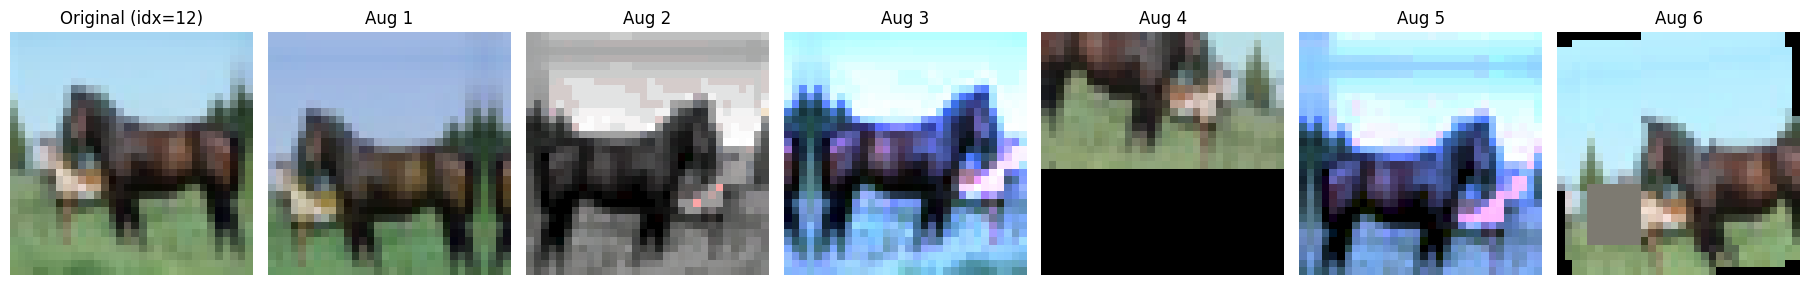

In [12]:
# =========================
# Visualização das Augmentations (original vs. versões aumentadas)

'''def _to_pil_from_chw_uint8(img_chw_uint8: np.ndarray) -> Image.Image:
    """Converte array (3, H, W) uint8 -> PIL.Image (RGB)."""
    assert img_chw_uint8.dtype == np.uint8 and img_chw_uint8.shape[0] == 3
    return Image.fromarray(np.transpose(img_chw_uint8, (1, 2, 0)))

class Denormalize(T.Normalize):
    """Inverte a normalização para visualização: x * std + mean."""
    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        super().__init__(mean=-mean/std, std=1/std)'''

def show_aug_example(idx: int, mean, std, n_aug: int = 6, use_autoaugment: bool = True, use_color_jitter: bool = True):

    img0_chw = X_train[idx]        # (3,32,32) uint8
    # usando ndarray HWC (não PIL) para casar com ToPILImage do pipeline
    img0_hwc = np.transpose(img0_chw, (1, 2, 0)).copy()

    tfms_train, _ = build_transforms(mean, std, use_autoaugment, use_color_jitter)
    denorm = Denormalize(mean, std)

    # gera variações
    aug_tensors = []
    for _ in range(n_aug):
        x = tfms_train(img0_hwc)       # passa ndarray -> ToPILImage cuida do resto
        x = denorm(x).clamp(0, 1)
        aug_tensors.append(x)

    # plot: original (usa CHW) + aumentadas
    cols = n_aug + 1
    plt.figure(figsize=(2.6*cols, 3))
    ax = plt.subplot(1, cols, 1)
    ax.imshow(np.transpose(img0_chw, (1, 2, 0)))
    ax.set_title(f"Original (idx={idx})")
    ax.axis("off")
    for i, x in enumerate(aug_tensors, start=2):
        ax = plt.subplot(1, cols, i)
        ax.imshow(np.transpose(x.numpy(), (1, 2, 0)))
        ax.set_title(f"Aug {i-1}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

show_aug_example(idx=12, mean=mean, std=std, n_aug=6,use_autoaugment=True, use_color_jitter=True)

## Arquitetura da Rede

In [13]:
# === Blocos da rede

# ========================= conv 2D → normalização de ativação (BN) → ReLU.
class ConvBNReLU(nn.Module):
    def __init__(self, in_ch: int, out_ch: int, k: int = 3, s: int = 1, p: str | int = "same"):
        super().__init__()
        if p == "same":
            # padding "mesmo tamanho" para k ímpar
            p = k // 2
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=k, stride=s, padding=p, bias=False)
        self.bn   = nn.BatchNorm2d(out_ch) # BN estabiliza a distribuição de ativações.
        self.act  = nn.ReLU(inplace=True) # ReLU introduz não linearidade e parcimônia de ativações.

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))



# ========================= Bloco Residual tipo “BasicBlock”: duas convs 3×3 com BN+ReLU e atalho (skip) que soma entrada à saída.
class ResidualBlock(nn.Module):
    """
    Dois Conv(3x3) com BN+ReLU + atalho (1x1) se canais mudarem.
    MaxPool(2x2) é aplicado FORA do bloco (no Stage) para manter o atalho estável.
    """
    def __init__(self, in_ch: int, out_ch: int):
        super().__init__()
        self.conv1 = ConvBNReLU(in_ch, out_ch, k=3, s=1, p="same")
        self.conv2 = ConvBNReLU(out_ch, out_ch, k=3, s=1, p="same")
        self.need_proj = (in_ch != out_ch)
        self.proj = nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False) if self.need_proj else nn.Identity()

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.need_proj:
            identity = self.proj(identity)
        out = out + identity
        out = F.relu(out, inplace=True)
        return out


# =======================
class BasicBlock(nn.Module):
    """Bloco residual estilo ResNet (3x3 -> 3x3) com atalho opcional 1x1 para casar shape."""
    def __init__(self, in_ch: int, out_ch: int, stride: int = 1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)

        # atalho (projection) se muda canal ou stride
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch),
            )
        else:
            self.shortcut = nn.Identity()

        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.act(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = out + self.shortcut(x)
        out = self.act(out)
        return out



# ========================= Sobel Stem: calcula magnitude do gradiente via filtros Sobel e concatena com entrada.
class SobelStem(nn.Module):
    # A ideia é dar à rede pistas explícitas de bordas, úteis em CIFAR-10 (objetos pequenos/texturizados).
    def __init__(self):
        super().__init__()
        kx = torch.tensor([[1, 0, -1],
                           [2, 0, -2],
                           [1, 0, -1]], dtype=torch.float32)
        ky = torch.tensor([[1,  2,  1],
                           [0,  0,  0],
                           [-1, -2, -1]], dtype=torch.float32)

        # buffers já no shape certo (3,1,3,3)
        self.register_buffer("kx3", kx.view(1,1,3,3).repeat(3,1,1,1))
        self.register_buffer("ky3", ky.view(1,1,3,3).repeat(3,1,1,1))

        self.dw_kx = nn.Conv2d(3, 3, kernel_size=3, padding=1, groups=3, bias=False)
        self.dw_ky = nn.Conv2d(3, 3, kernel_size=3, padding=1, groups=3, bias=False)
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, x: torch.Tensor):
        with torch.no_grad():
            self.dw_kx.weight.copy_(self.kx3)  # (3,1,3,3)
            self.dw_ky.weight.copy_(self.ky3)
        gx = self.dw_kx(x)
        gy = self.dw_ky(x)
        mag = torch.sqrt(gx * gx + gy * gy + 1e-6)
        # Custo: dobra canais de entrada do stem (3→6)
        return torch.cat([x, mag], dim=1)  # [B, 6, H, W]

In [15]:
# =================== fixando a aleatoriedade
def set_seed(seed: int = 42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# =========================
class EpochLogger:
    def __init__(self, enable: bool = True, every: int = 1):
        self.enable = enable
        self.every = every
        self.rows = []  # guarda histórico para uso posterior

    def log(self, epoch: int, epochs: int, tr_l: float, tr_a: float, va_l: float, va_a: float, lr: float):
        self.rows.append(
            {"epoch": epoch, "train_loss": tr_l, "train_acc": tr_a, "val_loss": va_l, "val_acc": va_a, "lr": lr}
        )
        if self.enable and (epoch % self.every == 0 or epoch == epochs):
            print(f"[{epoch:03d}/{epochs}] "
                  f"train_loss={tr_l:.4f} acc={tr_a*100:5.2f}% | "
                  f"val_loss={va_l:.4f} acc={va_a*100:5.2f}% | lr={lr:.5f}")



# ===== funções de treino/val
def train_one_epoch(model, loader: DataLoader, optimizer, scheduler, device, grad_clip=1.0):
    model.train()
    running_loss, running_acc, n = 0.0, 0.0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = F.cross_entropy(logits, yb)
        loss.backward()

        # grad_clip: limita norma dos gradientes para estabilidade
        if grad_clip is not None and grad_clip > 0:
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step() # atualiza pesos
        if scheduler is not None:
            scheduler.step()
        bs = yb.size(0)

        # Calculando a loss e acurácia médias da época
        running_loss += loss.item() * bs
        running_acc  += (logits.argmax(1) == yb).float().sum().item()
        n += bs
    return running_loss / n, running_acc / n



@torch.no_grad()
def evaluate(model, loader: DataLoader, device):
    model.eval()
    running_loss, running_acc, n = 0.0, 0.0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        logits = model(xb)
        loss = F.cross_entropy(logits, yb)
        bs = yb.size(0)
        running_loss += loss.item() * bs
        running_acc  += (logits.argmax(1) == yb).float().sum().item()
        n += bs
    return running_loss / n, running_acc / n



# ============================== relatório final no conjunto de teste.
@torch.no_grad()
def test_report(model, loader: DataLoader, device, class_names: List[str]):
    model.eval()
    all_preds, all_targets = [], []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        logits = model(xb)
        preds = logits.argmax(1).cpu().numpy().tolist()
        all_preds   += preds
        all_targets += yb.numpy().tolist()
    all_preds = np.array(all_preds); all_targets = np.array(all_targets)
    cm = confusion_matrix(all_targets, all_preds, labels=list(range(len(class_names))))
    acc_global = (all_preds == all_targets).mean()
    per_class_acc = {}
    for i, name in enumerate(class_names):
        mask = (all_targets == i)
        correct = (all_preds[mask] == i).sum()
        total = mask.sum()
        per_class_acc[name] = (correct / total) if total > 0 else float("nan")
    return float(acc_global), cm, per_class_acc


# ===== Config do treino =====
@dataclass
class TrainCfg:
    epochs: int = 30
    batch_size: int = 128
    lr: float = 0.2
    momentum: float = 0.9
    weight_decay: float = 0.0005
    grad_clip: float | None = 1.0
    use_sobel: bool = False
    base_channels: int = 64
    out_dir: str = "checkpoints"
    seed: int = 42
    eta_min: float = 0.0
    verbose: bool = True
    use_skip: bool = False

In [16]:
# ========================= Modelo completo

'''     Entrada: 3×32×32 (ou 6×32×32 com Sobel).
        Stem: ConvBNReLU(in_ch, 64) → 32×32
        Stage1: ResidualBlock(64→64) + MaxPool → 16×16
        Stage2: ResidualBlock(64→128) + MaxPool → 8×8
        Stage3: ResidualBlock(128→256) + MaxPool → 4×4
        Head: Conv 3×3 (256→256) + BN + ReLU → AdaptiveAvgPool2d(1) → B×256×1×1
        FC: Linear(256→10) → logits. '''

class CifarCNN(nn.Module):
    def __init__(self, num_classes: int = 10, base_channels: int = 64, use_sobel: bool = False, use_skip: bool = False):
        super().__init__()
        self.use_skip = use_skip
        self.use_sobel = use_sobel

        in_ch = 3
        if self.use_sobel:
            self.sobel = SobelStem()     # 3 -> 6
            in_ch = 6
        else:
            self.sobel = None

        C = base_channels

        # stem
        self.stem = ConvBNReLU(in_ch, C, k=3, s=1, p="same")

        # estágios
        if self.use_skip:
            # Estágio 1: mantém resolução
            self.stage1 = nn.Sequential(
                BasicBlock(C, C, stride=1),
                BasicBlock(C, C, stride=1),
            )
            # Estágio 2: downsample (stride=2) + bloco
            self.stage2 = nn.Sequential(
                BasicBlock(C, 2*C, stride=2),
                BasicBlock(2*C, 2*C, stride=1),
            )
            # Estágio 3: downsample + bloco
            self.stage3 = nn.Sequential(
                BasicBlock(2*C, 4*C, stride=2),
                BasicBlock(4*C, 4*C, stride=1),
            )
        else:
            # Variante "clássica": convs simples
            self.stage1 = nn.Sequential(
                ConvBNReLU(C,   C,   k=3, s=1, p="same"),
                ConvBNReLU(C,   C,   k=3, s=1, p="same"),
            )
            self.stage2 = nn.Sequential(
                ConvBNReLU(C,   2*C, k=3, s=2, p="same"),  # downsample por stride
                ConvBNReLU(2*C, 2*C, k=3, s=1, p="same"),
            )
            self.stage3 = nn.Sequential(
                ConvBNReLU(2*C, 4*C, k=3, s=2, p="same"),
                ConvBNReLU(4*C, 4*C, k=3, s=1, p="same"),
            )

        # cabeça
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc   = nn.Linear(4*C, num_classes)

    def forward(self, x):
        if self.use_sobel and self.sobel is not None:
            x = self.sobel(x)       # [B, 3] -> [B, 6] se ativado
        x = self.stem(x)        # [B, C]
        x = self.stage1(x)      # 32→16
        x = self.stage2(x)      # 16→8
        x = self.stage3(x)      # 8→4
        x = self.pool(x)
        x = torch.flatten(x, 1) # [B, C]
        x = self.fc(x)
        return x

In [17]:
# ===== Runner principal
def run_training(dl_train, dl_val, dl_test, class_names, cfg: TrainCfg, model_builder):

    """
    model_builder: função que devolve uma instância do seu modelo
    """

    set_seed(cfg.seed) # Reprodutibilidade (semente única)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("== Config ==", cfg); print("Device:", device)
    assert len(dl_train)>0 and len(dl_val)>0 and len(dl_test)>0, "Algum DataLoader está vazio!"

    # injeção de dependência:
    model = model_builder().to(device)
    print("Modelo:", model.__class__.__name__)


    # SGD com momentum + Cosine Annealing LR: padrão
    # weight_decay é L2 regularization (penaliza pesos grandes: menos overfitting).
    optimizer = SGD(model.parameters(), lr=cfg.lr, momentum=cfg.momentum, weight_decay=cfg.weight_decay)
    total_steps = cfg.epochs * len(dl_train)
    assert total_steps>0, "total_steps==0 (dl_train vazio?)"
    scheduler = CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=cfg.eta_min)

    logger = EpochLogger(enable=cfg.verbose, every=1)
    best_acc = -1.0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "lr": []}

    # garante que a pasta exista
    os.makedirs("data", exist_ok=True)
    best_path = "data/best.pt"

    for epoch in range(1, cfg.epochs+1):
        # grad_clip ajuda a estabilizar treinos (evita explosões de gradiente)
        tr_l, tr_a = train_one_epoch(
            model, dl_train, optimizer, scheduler, device, grad_clip=cfg.grad_clip
        )
        va_l, va_a = evaluate(model, dl_val, device)

        history["train_loss"].append(tr_l); history["train_acc"].append(tr_a)
        history["val_loss"].append(va_l);   history["val_acc"].append(va_a)
        history["lr"].append(optimizer.param_groups[0]["lr"])

        logger.log(epoch, cfg.epochs, tr_l, tr_a, va_l, va_a, optimizer.param_groups[0]["lr"])

        if va_a > best_acc:
            best_acc = va_a
            torch.save({
                "model": model.state_dict(),
                "epoch": epoch,
                "val_acc": best_acc
            }, best_path)

    # carrega melhor checkpoint
    ckpt = torch.load(best_path, map_location=device)
    model.load_state_dict(ckpt["model"])

    # Resultados finais
    acc, cm, per_class = test_report(model, dl_test, device, class_names)
    report = {"acc_global": float(acc), "cm": cm, "per_class_acc": per_class}
    return model, history, report, logger.rows

In [18]:
# Configuração de treino
cfg = TrainCfg(
    epochs=40,
    batch_size=128,
    lr=0.2,
    momentum=0.9,
    weight_decay=0.0005,
    grad_clip=1.0,
    use_sobel=False,
    use_skip=True,
    base_channels=64,
    out_dir="checkpoints",
    seed=42
)

# injeção no runner
model_builder = lambda: CifarCNN(
    num_classes=len(classes),
    use_sobel=cfg.use_sobel,
    use_skip=cfg.use_skip,
    base_channels=cfg.base_channels
)

# treino + avaliar no teste
model, history, report, rows = run_training(
    dl_train, dl_val, dl_test,
    classes,
    cfg,
    model_builder
)

== Config == TrainCfg(epochs=40, batch_size=128, lr=0.2, momentum=0.9, weight_decay=0.0005, grad_clip=1.0, use_sobel=False, base_channels=64, out_dir='checkpoints', seed=42, eta_min=0.0, verbose=True, use_skip=True)
Device: cuda
Modelo: CifarCNN
[001/40] train_loss=1.6427 acc=39.70% | val_loss=1.4170 acc=49.40% | lr=0.19969
[002/40] train_loss=1.1061 acc=60.28% | val_loss=1.2346 acc=56.76% | lr=0.19877
[003/40] train_loss=0.9050 acc=67.99% | val_loss=1.1548 acc=63.24% | lr=0.19724
[004/40] train_loss=0.7769 acc=72.96% | val_loss=0.8469 acc=70.82% | lr=0.19511
[005/40] train_loss=0.7086 acc=75.31% | val_loss=0.9825 acc=67.36% | lr=0.19239
[006/40] train_loss=0.6718 acc=76.90% | val_loss=0.8760 acc=71.28% | lr=0.18910
[007/40] train_loss=0.6247 acc=78.45% | val_loss=0.8418 acc=71.90% | lr=0.18526
[008/40] train_loss=0.6033 acc=79.24% | val_loss=0.6293 acc=77.62% | lr=0.18090
[009/40] train_loss=0.5856 acc=79.98% | val_loss=0.8511 acc=72.04% | lr=0.17604
[010/40] train_loss=0.5697 acc=80.

## Resultados

In [19]:
def print_results(report: Dict[str, Any], max_name_len: int = 10):
    acc = report["acc_global"]
    per_class = report["per_class_acc"]
    cm = report["cm"]

    print("\n== RESULTADOS (TESTE) ==")
    print(f"Acurácia global: {acc*100:.2f}%")

    print("\n\nAcurácia por classe:")
    for name, v in per_class.items():
        print(f"  {name:>{max_name_len}s}: {v*100:6.2f}%")

    print("\n\nMatriz de confusão:")
    print(cm)

def plot_history(history: Dict[str, list]):
    fig, axs = plt.subplots(1, 2, figsize=(11, 4))  # 1 linha, 2 colunas

    # Gráfico de Loss
    axs[0].plot(history["train_loss"], label="train_loss")
    axs[0].plot(history["val_loss"], label="val_loss")
    axs[0].set_xlabel("Época")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].set_title("Histórico de Loss")

    # Gráfico de Acurácia
    axs[1].plot(np.array(history["train_acc"]) * 100, label="train_acc (%)")
    axs[1].plot(np.array(history["val_acc"]) * 100, label="val_acc (%)")
    axs[1].set_xlabel("Época")
    axs[1].set_ylabel("Acurácia (%)")
    axs[1].legend()
    axs[1].set_title("Histórico de Acurácia")

    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(cm: np.ndarray, class_names: List[str], normalize: bool = False):
    if normalize:
        cm = cm.astype(float) / np.maximum(cm.sum(axis=1, keepdims=True), 1)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation="nearest")
    plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=45, ha="right")
    plt.yticks(ticks=np.arange(len(class_names)), labels=class_names)
    plt.title("Matriz de Confusão" + (" (normalizada)" if normalize else ""))
    plt.colorbar()
    # rótulos numéricos
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            txt = f"{cm[i,j]:.2f}" if normalize else str(cm[i,j])
            plt.text(j, i, txt, ha="center", va="center",
                     color="white" if cm[i,j] > thresh else "black")
    plt.tight_layout(); plt.xlabel("Predito"); plt.ylabel("Verdadeiro")
    plt.show()

In [20]:
print_results(report)


== RESULTADOS (TESTE) ==
Acurácia global: 94.25%


Acurácia por classe:
    airplane:  96.60%
  automobile:  98.00%
        bird:  91.90%
         cat:  86.90%
        deer:  95.00%
         dog:  90.50%
        frog:  95.90%
       horse:  96.10%
        ship:  96.00%
       truck:  95.60%


Matriz de confusão:
[[966   3   7   4   0   0   2   1  16   1]
 [  1 980   0   1   0   0   0   0   1  17]
 [ 16   0 919  23   9  13  16   3   1   0]
 [  9   1  19 869  15  62  13   6   4   2]
 [  2   0  10  10 950  16   5   7   0   0]
 [  4   0   9  57  12 905   3   7   2   1]
 [  4   0  14  15   1   5 959   1   0   1]
 [  3   0   4   9   6  16   0 961   1   0]
 [ 18   8   4   4   0   0   1   0 960   5]
 [  7  26   1   3   0   1   0   0   6 956]]


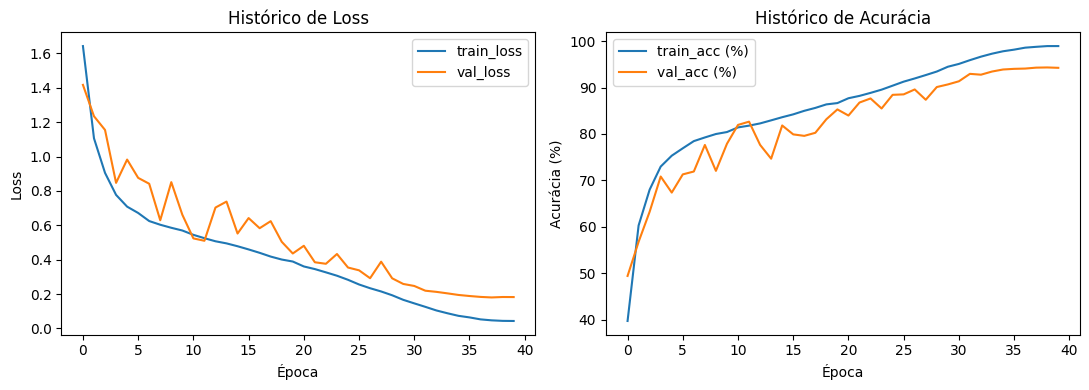

In [21]:
plot_history(history)

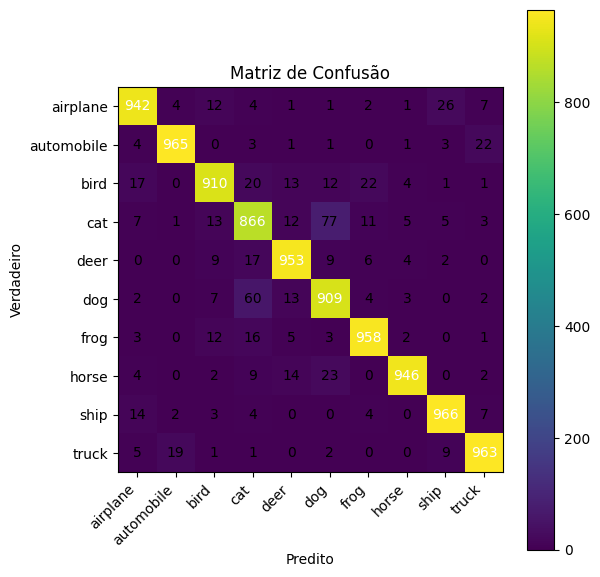

In [ ]:
plot_confusion_matrix(report["cm"], classes, normalize=False)

# 🧪 Resultados dos Treinos

| Treino      | Épocas | Batch | LR  | Sobel | Skip | Acurácia (Teste) | Obs.              |
| ----------- | ------ | ----- | --- | ----- | ---- | ---------------- | ----------------- |
| **11**      | 40     | 128   | 0.2 | ❌     | ✅    | **94.25%**       |
| **12**      | 40     | 128   | 0.2 | ✅     | ✅    | 93.78%       | –                 |
| **5**       | 40     | 128   | 0.2 | ❌     | ❌    | 93.13%       | –                 |
| **4**       | 30     | 128   | 0.2 | ❌     | ❌    | 92.46%           | –                 |
| **8**       | 30     | 256   | 0.2 | ❌     | ❌    | 92.44%           | –                 |
| **9**       | 40     | 256   | 0.2 | ❌     | ❌    | 92.38%           | –                 |
| **10**      | 40     | 256   | 0.2 | ❌     | ❌    | 91.92%           | Config resumida   |
| **Com Aug** | 30     | 128   | 0.2 | ❌     | ❌    | 91.79%           | Data Augmentation |
| **3**       | 30     | 128   | 0.1 | ❌     | ❌    | 91.72%           | –                 |
| **2**       | 20     | 128   | 0.1 | ❌     | ❌    | 91.27%           | –                 |
| **7**       | 20     | 256   | 0.1 | ❌     | ❌    | 90.99%           | –                 |
| **Extra**   | 20     | 264   | 0.1 | ❌     | ❌    | 90.82%           | Batch diferente   |
| **6**       | 20     | 128   | 0.1 | ✅     | ❌    | 90.20%           | Sobel ativo       |
| **1**       | 2      | 128   | 0.1 | ❌     | ❌    | 73.58%           | CPU               |


<br>

* Ativar **Skip connections (`use_skip=True`)** trouxe ganho expressivo (+1.1% no Treino 11).
* Usar **Sobel (`use_sobel=True`)** piorou desempenho (Treino 6).
* **Data Augmentation** trouxe leve melhora (≈ +0.1%), mas nada significativo.
